# Titanic - Machine Learning from Disaster

##### Python 3.8 Tenserflow 2.7 enviroment

## Import libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

## Load data

In [2]:
train_data = pd.read_csv('train.csv')
train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## Copy Dataframe

In [3]:
train_df = train_data.copy()

## Explore data

In [4]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
# Count missing values for train data
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

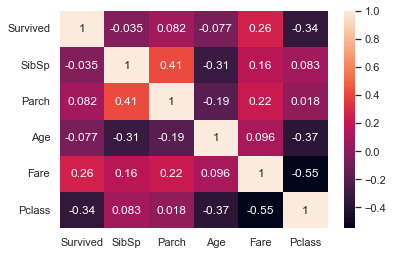

In [6]:
# Plot a heat map to see the correlation between the parameters and the target variable (Survived)
# The higher the (absolut?) value the higher the correlation
heatmap = sns.heatmap(train_df[['Survived', 'SibSp', 'Parch', 'Age', 'Fare', 'Pclass']].corr(), annot = True)
sns.set(rc={'figure.figsize':(7,5)})

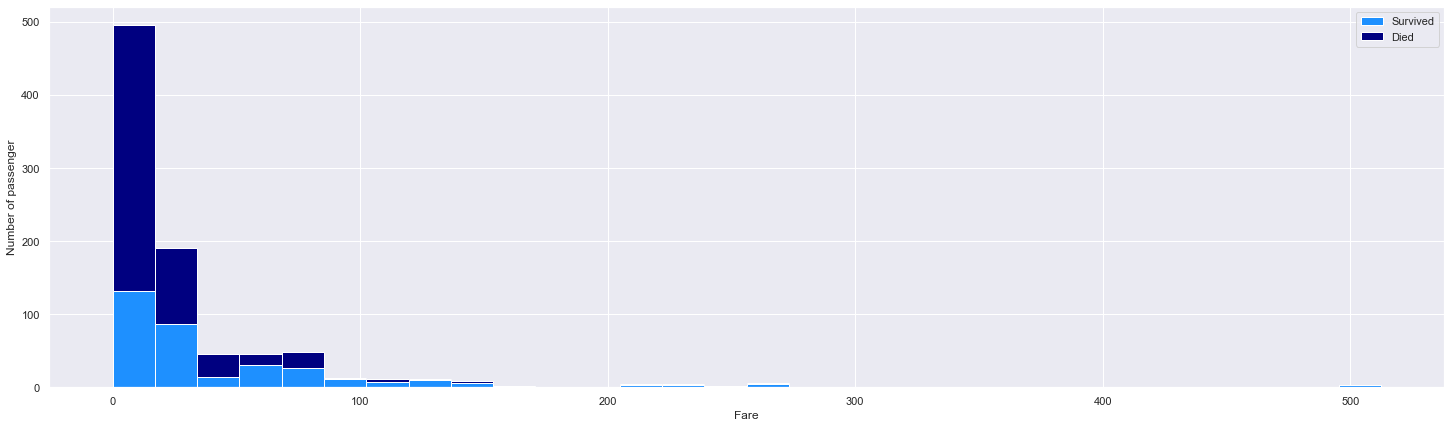

In [7]:
# Correlation between Fare and Surviving
plt.figure(figsize=(25, 7))
plt.hist([train_df[train_df['Survived']==1]['Fare'], train_df[train_df['Survived']==0]['Fare']], 
         stacked=True, color=['dodgerblue','navy'],
         bins=30, label=['Survived', 'Died']
        )
plt.xlabel('Fare')
plt.ylabel('Number of passenger')
plt.legend()

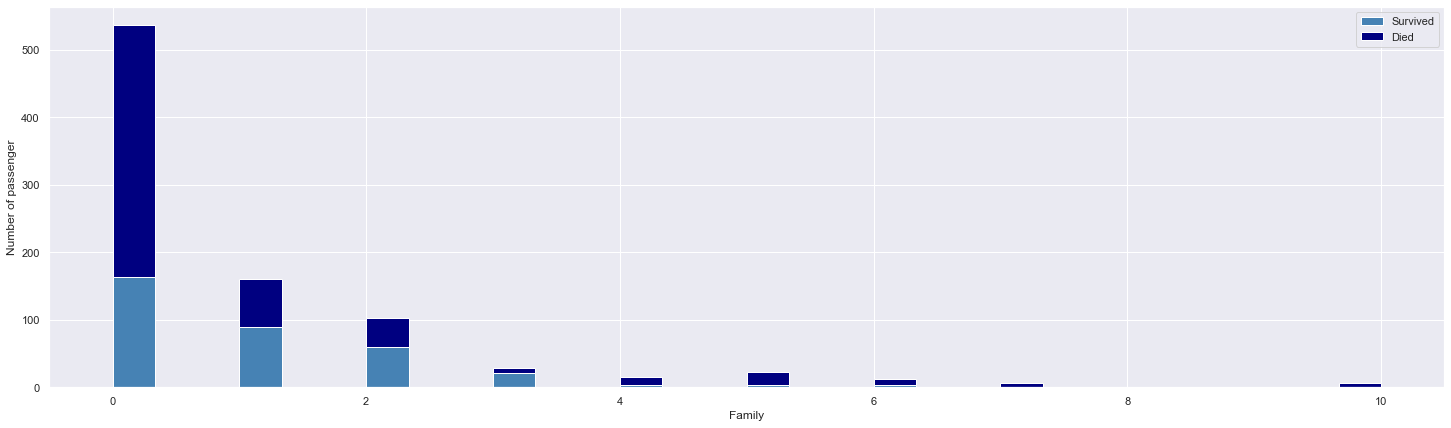

In [8]:
# Correlation between family size and Surviving
plt.figure(figsize=(25, 7))
plt.hist([train_df[train_df['Survived']==1]['Parch']+train_df[train_df['Survived']==1]['SibSp'],
          train_df[train_df['Survived']==0]['Parch']+train_df[train_df['Survived']==0]['SibSp']], 
          stacked=True, color=['steelblue','navy'],
          bins=30, label=['Survived', 'Died']
         )
plt.xlabel('Family')
plt.ylabel('Number of passenger')
plt.legend()

###### Seems pasangers with 1 to 3 family members have more chances to survive 

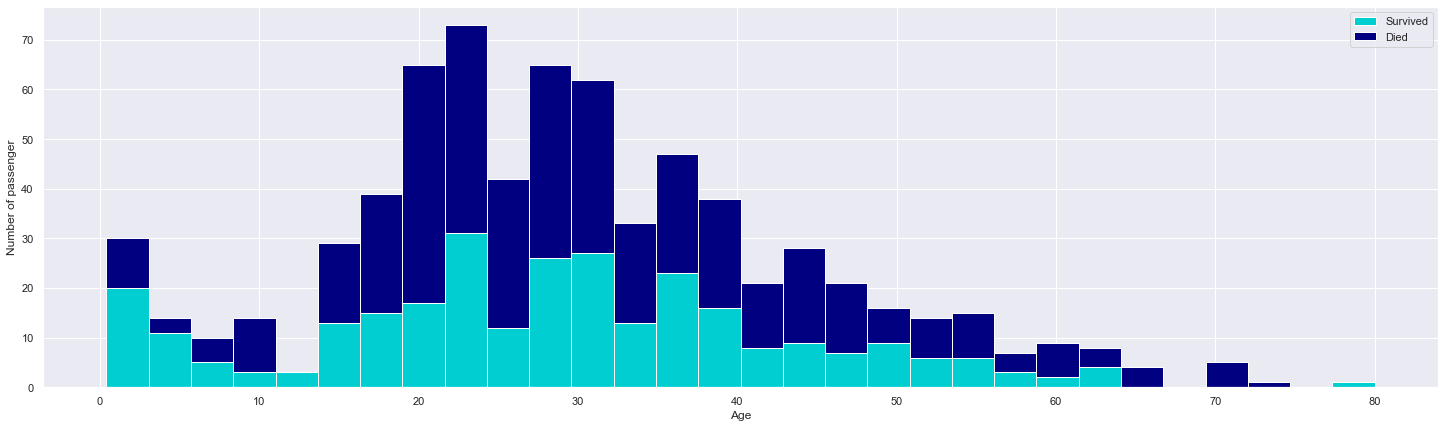

In [9]:
# Correlation between Age and Surviving
plt.figure(figsize=(25, 7))
plt.hist([train_df[train_df['Survived']==1]['Age'], train_df[train_df['Survived']==0]['Age']], 
         stacked=True, color=['darkturquoise','navy'],
         bins=30, label=['Survived', 'Died']
        )
plt.xlabel('Age')
plt.ylabel('Number of passenger')
plt.legend()

###### Seems there is higher rate of surviving only among children around less than 8

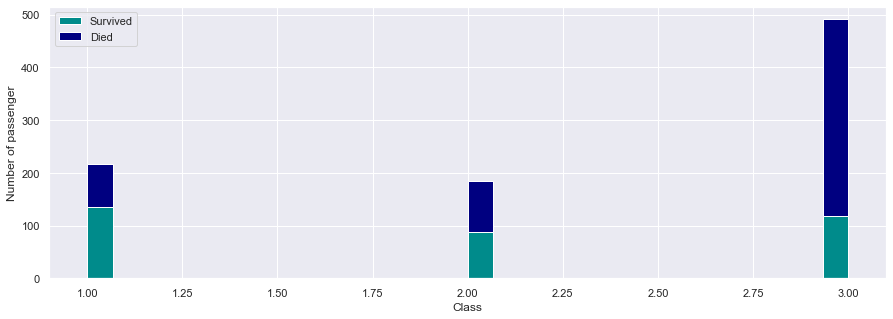

In [10]:
# Correlation between Class and Surviving
plt.figure(figsize=(15, 5))
plt.hist([train_df[train_df['Survived']==1]['Pclass'], train_df[train_df['Survived']==0]['Pclass']], 
         stacked=True, color=['darkcyan','navy'],
         bins=30, label=['Survived', 'Died']
        )
plt.xlabel('Class')
plt.ylabel('Number of passenger')
plt.legend()

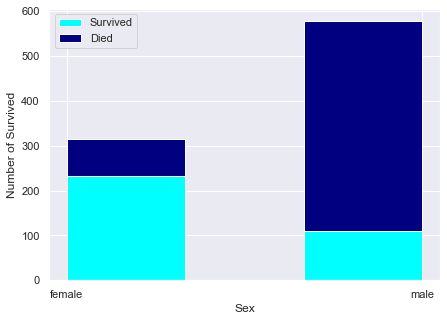

In [11]:
# Correlation between Gender and Surviving
plt.figure(figsize=(7, 5))
plt.hist([train_df[train_df['Survived']==1]['Sex'], train_df[train_df['Survived']==0]['Sex']], 
         stacked=True, color=['aqua','navy'],
         bins=3, label=['Survived', 'Died']
        )
plt.xlabel('Sex')
plt.ylabel('Number of Survived')
plt.legend()

###### Seems  women had more chances for surviving

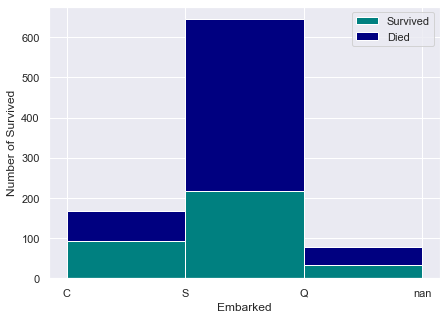

In [12]:
# Correlation between Embarked and Surviving
plt.figure(figsize=(7, 5))
plt.hist([train_df[train_df['Survived']==1]['Embarked'].map(lambda x: str(x)), 
          train_df[train_df['Survived']==0]['Embarked'].map(lambda x: str(x))], 
          stacked=True, color=['teal','navy'],
          bins=3, label=['Survived', 'Died']
         )
plt.xlabel('Embarked')
plt.ylabel('Number of Survived')
plt.legend()

## Data processing

### Missing age values

In [13]:
# Fill missing age values with random between mean-std and mean+std
age_mean = train_df["Age"].mean()
age_std = train_df["Age"].std()

# Remember age_mean and age_std to preprocess_data dictionary
preprocess_data = {'age_mean':age_mean, 'age_std':age_std}

def fill_missing_age(df, mean, std):
    is_null = df["Age"].isnull().sum()
    # compute random numbers in range of mean +/- std and size of is_null values
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = df["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    df["Age"] = age_slice
    df["Age"] = df["Age"].astype(int)
    return df

train_df = fill_missing_age(train_df, age_mean, age_std)

### Missing fare values

In [14]:
# Fill fare missing values with mean 
fare_mean = train_df["Fare"].mean()

# Remember fare mean to preprocess_data dictionary
preprocess_data['fare_mean'] = fare_mean
    
train_df['Fare'] = train_df['Fare'].fillna(train_df['Fare'].mean())

### Missing embarked values

In [15]:
# Fill missing values with most common
embarked_mode = train_df['Embarked'].mode().iloc[0]

# Remember embarked mode to preprocess_data dictionary
preprocess_data['embarked_mode'] = embarked_mode

train_df['Embarked'] = train_df['Embarked'].fillna(embarked_mode)

In [16]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

## Feature engineering

### Cabin

In [17]:
# Turn Cabin number into Deck 
decks = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', np.nan]

# Remember decks to preprocess_data dictionary
preprocess_data['decks'] = decks

def substring_in(inp, sub):
    for s in sub:
        if str(inp) == str(s) or str(inp).find(s) != -1:
            return s
    return

train_df['Deck'] = train_df['Cabin'].map(lambda x: substring_in(x, decks))

### Relatives

In [18]:
# Combine SibSp, Parch (siblings/spouse/parents/children) into new feature
train_df['Relatives'] = train_df['SibSp']+train_df['Parch']

In [19]:
# Extend field 'Relatives' into 3 categories: Singleton, SmallFamily, LargerFamily
def family_size(relatives):
    if relatives == 0:
        return 'Singleton'
    elif 0 < relatives <= 3:
        return 'SmallFamily'
    else:
        return 'LargerFamily'
    
train_df['Relatives'] = train_df['Relatives'].map(lambda x: family_size(x))
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,Relatives
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,NaN,SmallFamily
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,C,SmallFamily
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,NaN,Singleton
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,C,SmallFamily
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,NaN,Singleton


### Title

In [20]:
# Extract from Name field title (it might be that some education or profession correlate with surviving)
train_df['Title'] = train_df['Name'].map(lambda name: name.split(',')[1].split('.')[0].strip())
train_df['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

### Drop extra features

In [21]:
train_df = train_df.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1)
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Deck,Relatives,Title
0,0,3,male,22,7.2500,S,NaN,SmallFamily,Mr
1,1,1,female,38,71.2833,C,C,SmallFamily,Mrs
2,1,3,female,26,7.9250,S,NaN,Singleton,Miss
3,1,1,female,35,53.1000,S,C,SmallFamily,Mrs
4,0,3,male,35,8.0500,S,NaN,Singleton,Mr


## Scale numerical data

In [22]:
train_df.dtypes

Survived       int64
Pclass         int64
Sex           object
Age            int32
Fare         float64
Embarked      object
Deck          object
Relatives     object
Title         object
dtype: object

In [23]:
# Change Pclass type as it is a categorical variable
train_df['Pclass'] = train_df['Pclass'].astype(str)

In [24]:
from sklearn.preprocessing import StandardScaler

# Copy Dataframes before scaling
train_scaled = train_df.copy()

# Determine features to scale
features_to_scale = list(train_scaled.select_dtypes(include=['float64', 'int32']).columns)

# Fit scaler with train data
scaler = StandardScaler()
scaler.fit(train_scaled[features_to_scale])

# Remember features_to_scale and scaler to scale_data dictionary
scale_data = {'features_to_scale':features_to_scale, 'scaler':scaler}

# Transform numerical values
train_scaled[features_to_scale] = scaler.transform(train_scaled[features_to_scale])
train_scaled.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Deck,Relatives,Title
0,0,3,male,-0.548382,-0.502445,S,NaN,SmallFamily,Mr
1,1,1,female,0.633616,0.786845,C,C,SmallFamily,Mrs
2,1,3,female,-0.252883,-0.488854,S,NaN,Singleton,Miss
3,1,1,female,0.411992,0.420730,S,C,SmallFamily,Mrs
4,0,3,male,0.411992,-0.486337,S,NaN,Singleton,Mr


## Transform categorical variables into dummies

In [25]:
# Determine other features to encode with dummies
features_to_encode = list(train_scaled.select_dtypes(include=['object']).columns)
features_to_encode

['Pclass', 'Sex', 'Embarked', 'Deck', 'Relatives', 'Title']

In [26]:
from sklearn.preprocessing import OneHotEncoder
# Create binary dummies using OneHotEncoder to overcome the mismatch in features of train and test data
encoder = OneHotEncoder(drop='first', dtype='int64', handle_unknown = 'ignore')

# Remember features_to_encode, encoder to encode_data dictionary
encode_data = {'features_to_encode':features_to_encode, 'encoder':encoder}

encoded_df = encoder.fit_transform(train_scaled[features_to_encode])

encoded_features = encoder.get_feature_names_out(features_to_encode)
encoded_df = pd.DataFrame(encoded_df.todense(), columns=encoded_features)
encoded_df

,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,...,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Title_the Countess
0,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,1,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
887,0,0,0,0,1,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
888,0,1,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
889,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [27]:
# Concatenate scaled DataFrame and encoded DataFrame, drop already encoded features
train_encoded = pd.concat([train_scaled.copy(), encoded_df], axis=1)
train_encoded = train_encoded.drop(features_to_encode, axis=1)
train_encoded.head()

,Survived,Age,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Deck_B,Deck_C,...,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Title_the Countess
0,0,-0.548382,-0.502445,0,1,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1,0.633616,0.786845,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,1,-0.252883,-0.488854,0,1,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3,1,0.411992,0.420730,0,0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
4,0,0.411992,-0.486337,0,1,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


## Save data used for preprocess, scale and encode features into files

In [28]:
preprocess_data, scale_data, encode_data

({'age_mean': 29.69911764705882,
  'age_std': 14.526497332334042,
  'fare_mean': 32.204207968574636,
  'embarked_mode': 'S',
  'decks': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', nan]},
 {'features_to_scale': ['Age', 'Fare'], 'scaler': StandardScaler()},
 {'features_to_encode': ['Pclass',
   'Sex',
   'Embarked',
   'Deck',
   'Relatives',
   'Title'],
  'encoder': OneHotEncoder(drop='first', dtype='int64', handle_unknown='ignore')})

In [29]:
import pickle

with open('preprocess_data.pkl', 'wb') as f:
    pickle.dump(preprocess_data, f)
    
with open('scale_data.pkl', 'wb') as f:
    pickle.dump(scale_data, f)
    
with open('encode_data.pkl', 'wb') as f:
    pickle.dump(encode_data, f)

## Balance training data

In [30]:
died = train_encoded.query('Survived == 0')
survived = train_encoded.query('Survived == 1')
died['Survived'].value_counts(), survived['Survived'].value_counts()

(0    549
 Name: Survived, dtype: int64,
 1    342
 Name: Survived, dtype: int64)

In [31]:
balanced_df = pd.concat([survived, died.sample(len(survived), random_state=42)])
balanced_df['Survived'].value_counts()

1    342
0    342
Name: Survived, dtype: int64

## Split training data into train, validation and test sets

In [32]:
from sklearn.model_selection import train_test_split

# # Randomize data
# balanced_df = balanced_df.sample(frac=1)
features = balanced_df.columns[1:]
target = 'Survived'

# Split data into train and test sets in ratio 80%/20%  
X_train, X_test, y_train, y_test = train_test_split(balanced_df[features], 
                                                  balanced_df[target].to_numpy(), 
                                                  train_size=0.8,
                                                  random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((547, 33), (547,), (137, 33), (137,))

## Build prediction models

In [33]:
from sklearn.metrics import classification_report

## LogisticRegression

In [34]:
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, y_train)

# Returning classification report on logistic regression model prediction
print(classification_report(y_test, logistic_model.predict(X_test), target_names = ['Died', 'Survived']))

              precision    recall  f1-score   support

        Died       0.71      0.80      0.75        59
    Survived       0.83      0.76      0.79        78

    accuracy                           0.77       137
   macro avg       0.77      0.78      0.77       137
weighted avg       0.78      0.77      0.77       137



In [35]:
logistic_model.get_params(deep=True)

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

### Import GridSearchCV for auto search optimal hyperparameters

In [36]:
from sklearn.model_selection import GridSearchCV

**GridSearchCV** loops through every combination of the values in the grid,
 evaluating the performance using cross-validation to find the optimum combination of values

**estimator**: Model instance
<br>**param_grid**: Dictionary object that holds the hyperparameters we wish to experiment with
<br>**scoring**: Strategy to evaluate the performance of the cross-validated model on the test set
<br>**n_jobs**: Number of processes you wish to run in parallel for this task if it is -1 it will use all available processors
<br>**cv**: The total number of cross-validations we perform for each hyperparameter
<br>**verbose**: Detailed print out of your fit of the data
<br>**error_score**: Value to assign to the score if an error occurs in estimator fitting

### LogisticRegression hyperparameters tuning

**penalty**: Specify the norm of the penalty (regularisation technique to prevent overfitting)
<br>**C**: Inverse of regularization strength; must be a positive float. Smaller values specify stronger regularization
<br>**solver**: Algorithm to use in the optimization problem
<br>**max_iter**: Maximum number of iterations taken for the solvers to converge

In [37]:
# Silent warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

lm_params_grid = {'C': np.logspace(-4, 4, 20),
                  'solver': ['newton-cg','lbfgs','liblinear','sag','saga'],
                  'max_iter': [100, 1000, 2500, 5000]                
                 }

lm_grid = GridSearchCV(estimator=LogisticRegression(random_state=42),
                       param_grid=lm_params_grid,
                       n_jobs=-1,
                       cv=3,     
                       verbose=0,
                      )

lm_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'max_iter': [100, 1000, 2500, 5000],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']})

In [38]:
lm_grid.best_params_

{'C': 1.623776739188721, 'max_iter': 100, 'solver': 'saga'}

In [39]:
lm_param_tuned = LogisticRegression().set_params(**lm_grid.best_params_)
lm_param_tuned.fit(X_train, y_train)

# Returning classification report on tuned logistic regression model prediction
print(classification_report(y_test, lm_param_tuned.predict(X_test), target_names = ['Died', 'Survived']))

              precision    recall  f1-score   support

        Died       0.71      0.78      0.74        59
    Survived       0.82      0.76      0.79        78

    accuracy                           0.77       137
   macro avg       0.76      0.77      0.76       137
weighted avg       0.77      0.77      0.77       137



### Plot features by importance for Logistic Regression

In [40]:
def feature_importance(model):
    feat_imp = abs(model.coef_[0])
    feat_imp = pd.Series(feat_imp, features).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

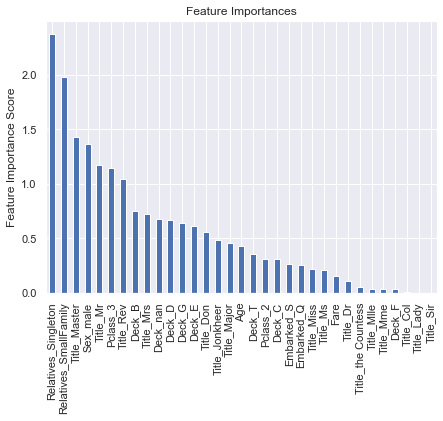

In [41]:
feature_importance(lm_param_tuned)

## Try HalvingGridSearchCV

In [42]:
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV

lm_halv = HalvingGridSearchCV(estimator=LogisticRegression(random_state=42),
                              param_grid=lm_params_grid,
                              n_jobs=-1,
                              cv=3,     
                              verbose=0,
                             )

lm_halv.fit(X_train, y_train)

HalvingGridSearchCV(cv=3, estimator=LogisticRegression(random_state=42),
                    n_jobs=-1,
                    param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                'max_iter': [100, 1000, 2500, 5000],
                                'solver': ['newton-cg', 'lbfgs', 'liblinear',
                                           'sag', 'saga']})

In [43]:
lm_halv.best_params_

{'C': 0.615848211066026, 'max_iter': 2500, 'solver': 'lbfgs'}

In [44]:
lm_halv_param_tuned = LogisticRegression().set_params(**lm_halv.best_params_)
lm_halv_param_tuned.fit(X_train, y_train)

# Returning classification report on tuned with HalvingGridSearchCV logistic regression model prediction
print(classification_report(y_test, lm_halv_param_tuned.predict(X_test), target_names = ['Died', 'Survived']))

              precision    recall  f1-score   support

        Died       0.71      0.80      0.75        59
    Survived       0.83      0.76      0.79        78

    accuracy                           0.77       137
   macro avg       0.77      0.78      0.77       137
weighted avg       0.78      0.77      0.77       137



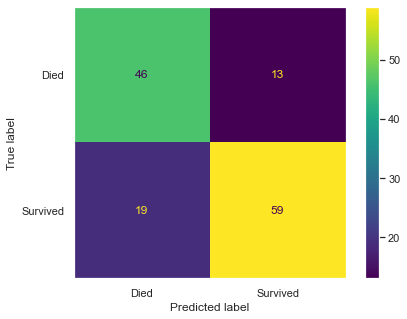

In [45]:
from sklearn.metrics import plot_confusion_matrix

# Plot confusion matrix for logistic regression with tuned hyperparameters
plot_confusion_matrix(lm_param_tuned, X_test, y_test, values_format='d', display_labels=['Died', 'Survived'])
plt.grid(False)

## Support Vector Machine

In [46]:
from sklearn import svm

clf_svm = svm.SVC(random_state=42)
clf_svm.fit(X_train, y_train)

SVC(random_state=42)

In [47]:
clf_svm.get_params(deep=True)

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [48]:
# Returning classification report on SVM model prediction
print(classification_report(y_test, clf_svm.predict(X_test), target_names = ['Died', 'Survived']))

              precision    recall  f1-score   support

        Died       0.70      0.85      0.77        59
    Survived       0.86      0.73      0.79        78

    accuracy                           0.78       137
   macro avg       0.78      0.79      0.78       137
weighted avg       0.79      0.78      0.78       137



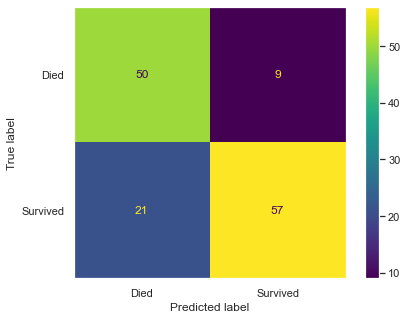

In [49]:
# Plot confusion matrix
plot_confusion_matrix(clf_svm, X_test, y_test, values_format='d', display_labels=['Died', 'Survived'])
plt.grid(False)

From **59** passengers who died **49(83%)** were correctly classified, and from **78** who survived **57(73%)** were correctly classified. 

## SVM hyperparameters tuning

**C**: C > 0, controls the trade off between smooth decision boundary and classifying the training points correctly
<br>**gamma**: higher gamma value tries to exactly fit the train data set
<br>**kernel**: selects the type of hyperplane, rbf stands for Radial Basis Function Kernel

In [50]:
svm_params_grid = {'C': [0.5, 1, 10, 100],  # 
                   'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
                   'kernel': ['rbf']           
                  }

svm_grid = GridSearchCV(estimator=svm.SVC(random_state=42),
                        param_grid=svm_params_grid,
                        scoring='recall',  # this scorring parameter showed the best result
                        n_jobs=-1,
                        cv=5,     
                        verbose=0,
                       )

svm_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.5, 1, 10, 100],
                         'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             scoring='recall')

In [51]:
svm_grid.best_params_    # best parameters {'C': 0.5, 'gamma': 1, 'kernel': 'rbf'}

{'C': 0.5, 'gamma': 1, 'kernel': 'rbf'}

In [52]:
svm_grid_param_tuned = svm.SVC().set_params(**svm_grid.best_params_)
svm_grid_param_tuned.fit(X_train, y_train)

# Returning classification report on tuned SVM model prediction
print(classification_report(y_test, svm_grid_param_tuned.predict(X_test), target_names = ['Died', 'Survived']))

              precision    recall  f1-score   support

        Died       0.79      0.78      0.79        59
    Survived       0.84      0.85      0.84        78

    accuracy                           0.82       137
   macro avg       0.81      0.81      0.81       137
weighted avg       0.82      0.82      0.82       137



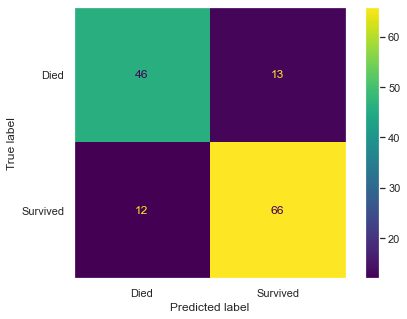

In [53]:
# Plot confusion matrix
plot_confusion_matrix(svm_grid_param_tuned, X_test, y_test, values_format='d', display_labels=['Died', 'Survived'])
plt.grid(False)

In [54]:
best_result = 82

if int(svm_grid_param_tuned.score(X_test, y_test).round(2)*100) >= best_result:

    file_name = f"svm_{str(int(svm_grid_param_tuned.score(X_test, y_test).round(2)*100))}.pkl"

    with open(file_name, 'wb') as f:
        pickle.dump(svm_grid_param_tuned, f)

## Load and  preprocess new data

In [55]:
# Load new data
test_data = pd.read_csv('test.csv')
test_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [56]:
# Copy data and explore
test_df = test_data.copy()
test_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


### Preprocess new data

In [57]:
def new_data_preprocess(df):
    # Load preprocessing data
    with open('preprocess_data.pkl', 'rb') as f:
        preprocess_data = pickle.load(f)
        
    # Fill missing age values
    df = fill_missing_age(df, preprocess_data['age_mean'], preprocess_data['age_std'])
    
    # Fill missing fare values
    df['Fare'] = df['Fare'].fillna(preprocess_data['fare_mean'])
    
    # Fill missing embarked values if any
    df['Embarked'] = df['Embarked'].fillna(preprocess_data['embarked_mode'])
    
    # Turn Cabin number into Deck    
    df['Deck'] = df['Cabin'].map(lambda x: substring_in(x, preprocess_data['decks']))
    
    # Combine SibSp, Parch (siblings/spouse/parents/children) into new feature
    df['Relatives'] = df['SibSp']+df['Parch']
    # Extend field 'Relatives' into 3 categories: Singleton, SmallFamily, LargerFamily with family_size() function
    df['Relatives'] = df['Relatives'].map(lambda x: family_size(x))
    
    # Extract from Name field title (it might be that some education or profession correlate with surviving)
    df['Title'] = df['Name'].map(lambda name: name.split(',')[1].split('.')[0].strip())
    
    # Drop extra features
    df = df.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1)

    return df

test_df = new_data_preprocess(test_df)
test_df

,Pclass,Sex,Age,Fare,Embarked,Deck,Relatives,Title
0,3,male,34,7.8292,Q,NaN,Singleton,Mr
1,3,female,47,7.0000,S,NaN,SmallFamily,Mrs
2,2,male,62,9.6875,Q,NaN,Singleton,Mr
3,3,male,27,8.6625,S,NaN,Singleton,Mr
4,3,female,22,12.2875,S,NaN,SmallFamily,Mrs
...,...,...,...,...,...,...,...,...
413,3,male,41,8.0500,S,NaN,Singleton,Mr
414,1,female,39,108.9000,C,C,Singleton,Dona
415,3,male,38,7.2500,S,NaN,Singleton,Mr
416,3,male,42,8.0500,S,NaN,Singleton,Mr


### Scale new data numerical values

In [58]:
def new_data_scale(df):
    # Change Pclass type as it is a categorical variable
    df['Pclass'] = df['Pclass'].astype(str)

    # Load scale data
    with open('scale_data.pkl', 'rb') as f:
        scale_data = pickle.load(f)

    #Transform numerical values
    scaler, features_to_scale = scale_data['scaler'], scale_data['features_to_scale']
    df[features_to_scale] = scaler.transform(df[features_to_scale])
        
    return df

# Copy Dataframes before scaling
test_scaled = test_df.copy()

test_scaled = new_data_scale(test_scaled)
test_scaled

,Pclass,Sex,Age,Fare,Embarked,Deck,Relatives,Title
0,3,male,0.338117,-0.490783,Q,NaN,Singleton,Mr
1,3,female,1.298490,-0.507479,S,NaN,SmallFamily,Mrs
2,2,male,2.406614,-0.453367,Q,NaN,Singleton,Mr
3,3,male,-0.179008,-0.474005,S,NaN,Singleton,Mr
4,3,female,-0.548382,-0.401017,S,NaN,SmallFamily,Mrs
...,...,...,...,...,...,...,...,...
413,3,male,0.855241,-0.486337,S,NaN,Singleton,Mr
414,1,female,0.707491,1.544246,C,C,Singleton,Dona
415,3,male,0.633616,-0.502445,S,NaN,Singleton,Mr
416,3,male,0.929116,-0.486337,S,NaN,Singleton,Mr


### Transform new data categorical variables into dummies

In [59]:
def new_data_one_hot(df):
    # Load encode data
    with open('encode_data.pkl', 'rb') as f:
        encode_data = pickle.load(f)
    
    # Transform features listed in features_to_encode into dummies
    encoder, features_to_encode = encode_data['encoder'], encode_data['features_to_encode']
    encoded_df = encoder.transform(df[features_to_encode])

    # Get DataFrame from dummies matrix
    encoded_features = encoder.get_feature_names_out(features_to_encode)    
    encoded_df = pd.DataFrame(encoded_df.todense(), columns=encoded_features)
    
    # Concatenate scaled DataFrame and encoded DataFrame, drop already encoded features
    df = pd.concat([df, encoded_df], axis=1)
    df = df.drop(features_to_encode, axis=1)    
    return df

# Copy Dataframes before scaling
test_encoded = test_scaled.copy()

test_encoded = new_data_one_hot(test_encoded)
test_encoded

,Age,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Deck_B,Deck_C,Deck_D,...,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Title_the Countess
0,0.338117,-0.490783,0,1,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1.298490,-0.507479,0,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,2.406614,-0.453367,1,0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,-0.179008,-0.474005,0,1,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,-0.548382,-0.401017,0,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0.855241,-0.486337,0,1,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
414,0.707491,1.544246,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
415,0.633616,-0.502445,0,1,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
416,0.929116,-0.486337,0,1,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


### Check there is no mismatch in features in train and new data sets

In [60]:
comparison = train_encoded.columns.values[1:] == test_encoded.columns.values
equal_features = comparison.all()
  
print(equal_features)

True


## Run best perforemed model on new data and save prediction as submission.csv 